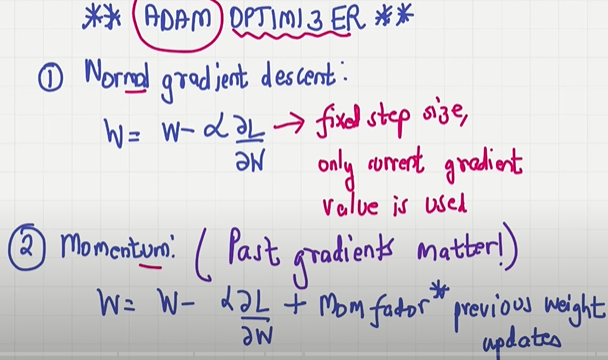

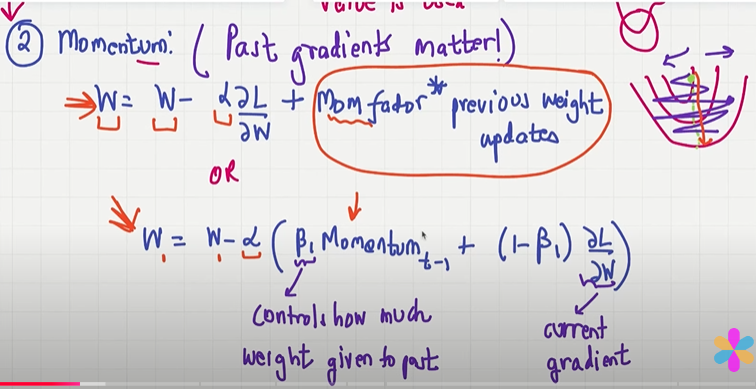

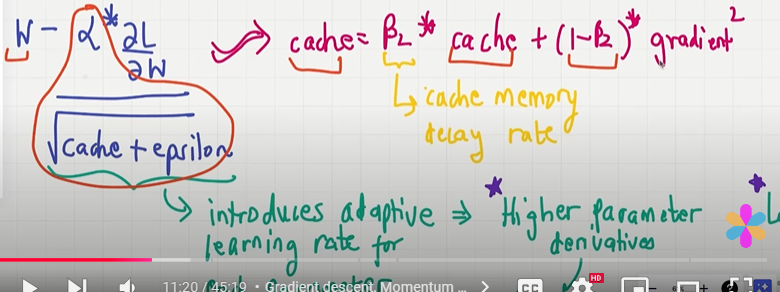

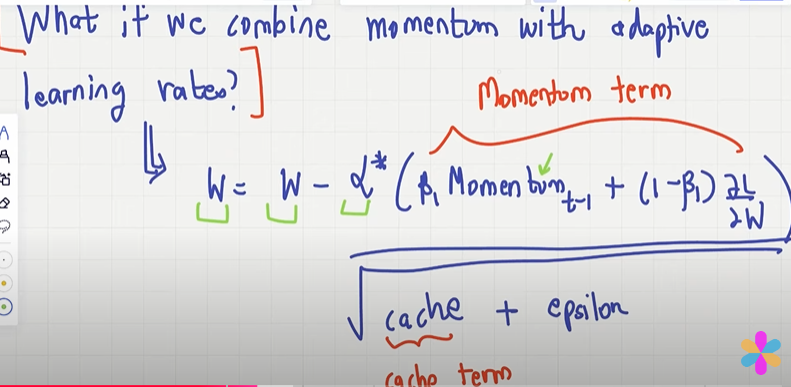

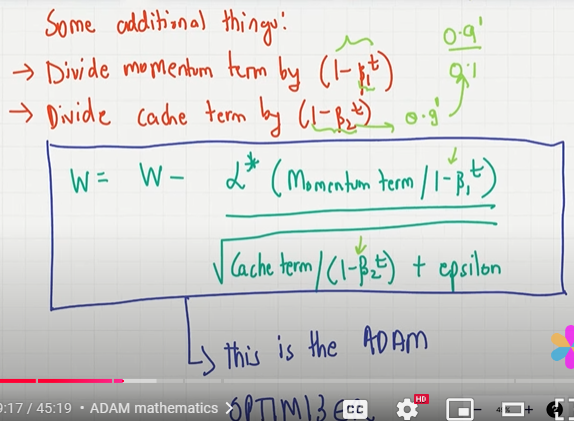
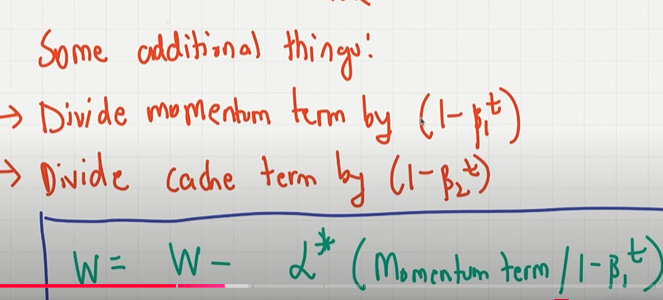

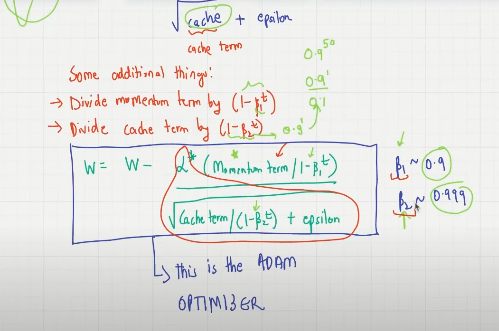

In [1]:
import numpy as np

# Adam optimizer
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first pass and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


In [2]:
from Dense_Layer import Layer_Dense
from ReLU_Act import Activation_ReLU
from SGD_optimizer import Optimizer_SGD
from Softmax_Act import Activation_Softmax
from Cat_Crossentropy_Loss import Loss_Categorical_Crossentropy
from softmax_loss_catcrossentropy import Activation_Softmax_Loss_CategoricalCrossentropy
from ADAGRAD_optimizer import Optimizer_Adagrad
from RMSProp_optimizer import Optimizer_RMSprop
from Adam_optimizer import Optimizer_Adam

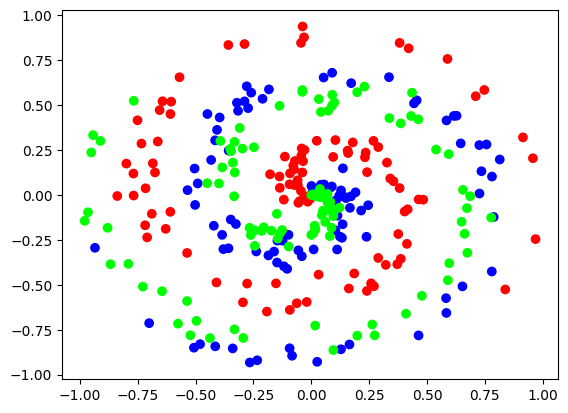

In [3]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
nnfs.init()
import matplotlib.pyplot as plt
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [4]:
import numpy as np

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
#optimizer = Optimizer_SGD(decay=8e-8, momentum=0.9)
#optimizer = Optimizer_Adagrad(decay=1e-4)
#optimizer = Optimizer_RMSprop(decay=1e-4)
#optimizer = Optimizer_RMSprop(learning_rate=0.02, decay=1e-5,rho=0.999)

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.343, loss: 1.099, lr: 0.02
epoch: 100, acc: 0.490, loss: 0.981, lr: 0.01998021958261321
epoch: 200, acc: 0.543, loss: 0.876, lr: 0.019960279044701046
epoch: 300, acc: 0.580, loss: 0.838, lr: 0.019940378268975763
epoch: 400, acc: 0.610, loss: 0.801, lr: 0.01992051713662487
epoch: 500, acc: 0.730, loss: 0.728, lr: 0.01990069552930875
epoch: 600, acc: 0.710, loss: 0.674, lr: 0.019880913329158343
epoch: 700, acc: 0.730, loss: 0.637, lr: 0.019861170418772778
epoch: 800, acc: 0.737, loss: 0.613, lr: 0.019841466681217078
epoch: 900, acc: 0.763, loss: 0.601, lr: 0.01982180200001982
epoch: 1000, acc: 0.767, loss: 0.588, lr: 0.019802176259170884
epoch: 1100, acc: 0.763, loss: 0.579, lr: 0.01978258934311912
epoch: 1200, acc: 0.767, loss: 0.575, lr: 0.01976304113677013
epoch: 1300, acc: 0.757, loss: 0.568, lr: 0.019743531525483964
epoch: 1400, acc: 0.763, loss: 0.562, lr: 0.01972406039507293
epoch: 1500, acc: 0.767, loss: 0.557, lr: 0.019704627631799327
epoch: 1600, acc: 0.780, lo